# Domain decomposition example using shallow water gravity wave and Dask

This example is to demonstrate how to decompose domain and run computation
on Dask's clusters using domain split API. This notebook is based on
[1_gravity_wave.ipynb](./1_gravity_wave.ipynb), and it is recommended to familiarize with it first.

## Set the grid

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  multimodemodel import StaggeredGrid

nx, ny = 100, 100
dx, dy = 1., 1.

x = np.arange(0., dx * nx, dx)
y = np.arange(0., dy * ny, dy)

c_grid = StaggeredGrid.cartesian_c_grid(x=x, y=y)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Set the initial state

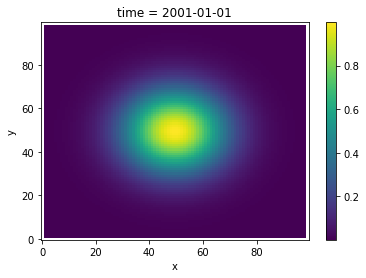

In [2]:
from multimodemodel import State, Variable, str_to_date

x, y = c_grid.eta.x, c_grid.eta.y
eta = np.exp(
    -((x - x.mean()) ** 2 + (y - y.mean()) ** 2)
    / (x.max() // 5) ** 2
)

t0 = str_to_date("2001-01-01 00:00")

initial_state = State(
    u=Variable(None, c_grid.u, t0),
    v=Variable(None, c_grid.v, t0),
    eta=Variable(eta, c_grid.eta, t0)
)
initial_state.eta.as_dataarray.plot(x='x', y='y')

## Define the problem to solve

In [3]:
from multimodemodel import (
    pressure_gradient_i,
    pressure_gradient_j,
    divergence_i,
    divergence_j,
    sum_states,
    Parameter,
)

params = Parameter(H=1.)

def non_rotating_swe(state, params):
    rhs = sum_states(
        (
            pressure_gradient_i(state, params),
            pressure_gradient_j(state, params),
            divergence_i(state, params),
            divergence_j(state, params)
        )
    )
    return rhs

## Start up dask cluster to work on

We want to split the domain into 4 parts and start a worker for each subdomain. Each worker will have two threads to be able to do asynchroneous communication.

In [4]:
from dask.distributed import Client

# monkey patch to speed up dask client
from functools import lru_cache
import inspect
inspect.getsource = lru_cache(inspect.getsource)

parts = 4
domains_per_worker = 1
client = Client(
    n_workers=parts//domains_per_worker,
    threads_per_worker=domains_per_worker+1
)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55536,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:55550,Total threads: 2
Dashboard: http://127.0.0.1:55553/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:55542,


## Define iteration workflow


We use the `DaskWorkflow` manager to distribute the computation on the previously created dask cluster.

In [5]:
from multimodemodel.workflow import DaskWorkflow
from multimodemodel import (
    RegularSplitMerger,
    Domain,
    Solver,
    adams_bashforth3,
)

workflow = DaskWorkflow(
    domain=Domain(state=initial_state, parameter=params),
    solver=Solver(rhs=non_rotating_swe, ts_schema=adams_bashforth3, step=0.05),
    splitter=RegularSplitMerger(parts=parts, dim=(0,)),
    client=client
)

## Perform computation

The workflow will assign a future to its `domain` attribute, hence the `run` method returns when the client has finished to compute the graph. To measure total run time, we also wait for the final result of the computation. 

In [6]:
%%time
workflow.run(steps=500)

# wait for the graph to be evaluated
result = workflow.domain.result()

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 11.5 s, sys: 1.68 s, total: 13.2 s
Wall time: 19.6 s


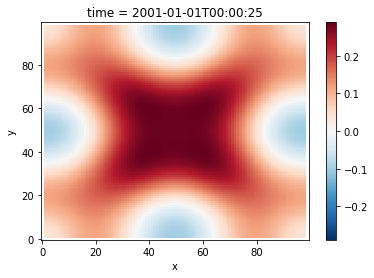

In [7]:
workflow.domain.result().state.eta.as_dataarray.plot(x='x', y='y')